# 验证码识别-TFLearn 版-单字符

同是从带多个字符的图片中学习特征，同时对应多个输出分类(4个字符)

# 准备数据

In [1]:
%matplotlib inline
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

image_dir = "/Volumes/Cloud/DataSet/src/captcha"
model_dir = "/Volumes/Cloud/Models/captcha/resnet"

LABEL_LENGTH = 4        # 验证码字符数
#LABELS = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
LABELS = "0123456789"   # 验证码字符组成

IMAGE_H = 28            # 缩放后单个字符图片大小
IMAGE_W = 28            # 缩放后单个字符图片大小
IMAGE_C = 3             # 图片通道数

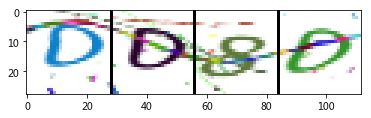

In [2]:
# 读图
def read_image(filename):
    image = cv2.imread(filename)  # 读 PNG 只会读到3个通道
    #image = mpimg.imread(filename) 
    h,w = image.shape[:2]
    image = image[0:h,12:w-6]
    image = cv2.resize(image,(IMAGE_W*LABEL_LENGTH,IMAGE_H),cv2.INTER_LINEAR) # 缩放大小
    return image

filename = os.path.join(image_dir,os.listdir(image_dir)[9])

image = read_image(filename)

# 看等比例切分是否合适
h = image.shape[0]
sw = IMAGE_W
for i in range(LABEL_LENGTH-1):
    x = sw*(i+1)
    image[0:h,x:x+1]=0
plt.imshow(image);

## 图片前期处理

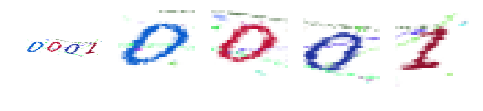

In [3]:
def plot_image(image):
    plt.axis('off');
    plt.imshow(image)

# 切分图片
def split_image(image):
    images = []
    h = image.shape[0]
    sw = IMAGE_W
    for i in range(LABEL_LENGTH):
        x = sw*i
        images.append(image[0:h,x:x+sw])

    return images

image = read_image(os.path.join(image_dir,os.listdir(image_dir)[0]))
simgs = split_image(image)

plt.figure(figsize=(8,3))
plt.subplot(1, 5, 1)
plot_image(image)

for i in range(len(simgs)):
    plt.subplot(1, 5, i+2)
    plot_image(simgs[i])

plt.show()

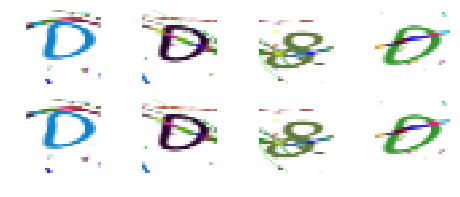

In [4]:
# 对比度增强
def enhance_contrast(image,contrast=1.5): 
    rows,cols,channels=image.shape
    dst=image.copy()

    a=contrast
    b=100
    for i in range(rows):
        for j in range(cols):
            for c in range(3):
                color=image[i,j][c]*a+b
                if color>255:
                    dst[i,j][c]=255
                elif color<0:
                    dst[i,j][c]=0
    return dst

# 返回去燥用的掩码
def get_noise_mask_hsv(image):
    # 转换为 HSV 后只进行去燥掩码计算
    #H是色彩，范围0° ~ 360°，红（0°）、绿（120°）、蓝（240°）；
    #S是深浅， S = 0时，只有灰度，越往圆心的位置越偏白；
    #V是明暗

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).reshape(-1,3)

    def is_keep_color(x,v,t=60):
        return v-t<=x and x<=v+t

    h = []
    s = []
    v = []
    for x in hsv:
        if not(x[0]==0 and x[1]==0 and x[2]==255):
            h.append(x[0])
            s.append(x[1])
            v.append(x[2])

    h = np.argmax(np.bincount(np.array(h,dtype=np.uint8)))  
    s = np.argmax(np.bincount(np.array(s,dtype=np.uint8)))  
    v = np.argmax(np.bincount(np.array(v,dtype=np.uint8)))  

    mask = []
    for x in hsv:
        #if is_keep_color(x[0], h, 20) and is_keep_color(x[1], s) and is_keep_color(x[2], v):
        if is_keep_color(x[0], h, 20):
            mask.append(255)
        else:
            mask.append(0)

    mask = np.array(mask).reshape((image.shape[:2])) # 掩码
    return mask


# 用HSV聚类进行去燥
def remove_noise_hsv(image):
    h,w,_ = image.shape
    sw = int(w/LABEL_LENGTH)
    for i in range(LABEL_LENGTH):
        x = sw*i
        mask = image.copy()
        mask[0:h,0:x]    = 255
        mask[0:h,x+sw:w] = 255

        mask = get_noise_mask_hsv(mask)

        mask[0:h,0:x]    = 255
        mask[0:h,x+sw:w] = 255

        image[mask==0]=255  # 进行掩码计算

    return image

# 验证码去燥
def remove_noise_gray(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # 自适应阈值
    gray = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2) 

    image = image.copy()
    image[gray!=0]=255

    return image

from scipy import ndimage

# 验证码去燥
def remove_noise(image):
    image = enhance_contrast(image)
    #image = remove_noise_hsv(image)
    image = remove_noise_gray(image)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    gray[gray!=255]=0

    gray = ndimage.binary_erosion(gray,iterations=5)
    #gray = ndimage.binary_dilation(gray,iterations=1)
    #gray = ndimage.binary_erosion(gray,iterations=2)

    image[gray!=0]=255

    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    gray[gray!=255]=0

    gray = ndimage.binary_erosion(gray,iterations=2)
    gray = ndimage.binary_dilation(gray,iterations=2)

    # 清理一下边界
    gray[0:4,:] = 255
    gray[gray.shape[0] - 4:, :] = 255
    gray[:,0:4] = 255
    gray[:,gray.shape[1] - 4:] = 255

    return gray

# 验证码去燥
def remove_noise(image):
    #image = enhance_contrast(image)
    #image = remove_noise_gray(image)
    #image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    #image[image!=255]=0
    #global IMAGE_C
    #IMAGE_C = 1

    return image

filename=os.path.join(image_dir,os.listdir(image_dir)[0])
image = read_image(os.path.join(image_dir,os.listdir(image_dir)[9]))
simgs = split_image(image)

plt.figure(figsize=(8,3))

for i in range(len(simgs)):
    plt.subplot(2, LABEL_LENGTH, i+1)
    plt.axis('off');
    plt.imshow(simgs[i])
    plt.subplot(2, LABEL_LENGTH, i+1+LABEL_LENGTH)
    plot_image(remove_noise(simgs[i]))

plt.show()

## 构建训练集和测试集

In [5]:
import os
import cv2
import numpy as np
from sklearn import model_selection
import tqdm

# 读取图片、二值化、灰度图，Label 编码为 OneHot 格式
def load_data(path):
    # OneHot
    def char_to_vec(c):
        y = np.zeros((len(LABELS),))
        y[LABELS.index(c)] = 1.0
        return y

    labels = []
    images = []
    sfiles = []
    fnames = os.listdir(path)
    with tqdm.tqdm(total=len(fnames)) as pbar:
        for i,name in enumerate(fnames):
            if name.endswith(".jpg") or name.endswith(".jpeg") or name.endswith(".png"):
                image = read_image(os.path.join(path,name))
                # Convert from [0, 255] -> [0.0, 1.0].
                image = image.astype(np.float32)
                image = image/255.0

                simgs = split_image(image)
                label = name[:LABEL_LENGTH].upper()

                for k in range(LABEL_LENGTH):
                    labels.append(char_to_vec(label[k]))
                    images.append(remove_noise(simgs[k]))
                    sfiles.append(name)
                pbar.update(1)

    images = np.array(images)
    if IMAGE_C == 1:
        images = images.reshape(images.shape + (1,))
    labels = np.array(labels)
    labels = labels.reshape((labels.shape[0],-1))
    sfiles = np.array(sfiles)

    return images, labels, sfiles

# 
class DataSet(object):
    def __init__(self, images, labels):
        assert images.shape[0] == labels.shape[0], (
            "images.shape: %s labels.shape: %s" % (images.shape,
                                                   labels.shape))
        self._num_examples = images.shape[0]
        self._images = images
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self._images[start:end], self._labels[start:end]
class DataSets(object):
    pass

images,labels,sfiles = load_data(image_dir)
images.shape, labels.shape, sfiles.shape

100%|██████████| 999/999 [00:00<00:00, 1803.38it/s]


((3996, 28, 28, 3), (3996, 10), (3996,))

In [6]:
# Onehot 编码转换回字符串
def onehot2number(label):
    return LABELS[np.argmax(label)]

labels[0],onehot2number(labels[0])

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), '0')

## 数据分布

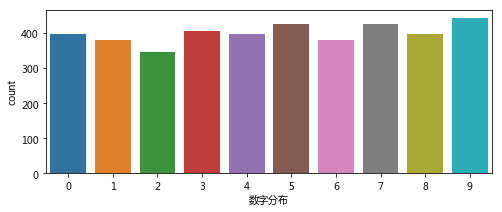

In [7]:
a = []
for i,label in enumerate(labels):
    label = onehot2number(label)
    a.append([i,label])

import pandas as pd
df = pd.DataFrame(a,columns=['i','label'])
import seaborn as sns

plt.figure(figsize=(8,3))
sns.countplot(df['label']);
plt.xlabel('数字分布');

### 进行数据平衡

max 443


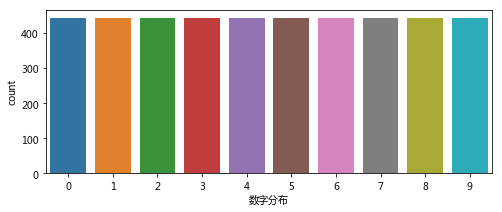

In [8]:
groupby_counts = df.groupby('label').size()
samples = groupby_counts.max().max()
print('max', samples)
df_groupby = df.groupby('label')
df = df_groupby.apply(lambda x: x.sample(samples, replace=True)).reset_index(drop=True)

plt.figure(figsize=(8,3))
sns.countplot(df['label']);
plt.xlabel('数字分布');

In [9]:
new_images=[]
new_labels=[]
new_sfiles=[]
for i in df['i']:
    new_images.append(images[i])
    new_labels.append(labels[i])
    new_sfiles.append(sfiles[i])
images = np.array(new_images)
labels = np.array(new_labels)
sfiles = np.array(new_sfiles)

In [10]:
def make_data_sets(images,labels):
    trainX, testX, trainY, testY = model_selection.train_test_split(images, labels, test_size=0.20, random_state=42)

    data_sets = DataSets()
    data_sets.train = DataSet(trainX,trainY)
    data_sets.test  = DataSet(testX,testY)
    
    return data_sets

data_sets = make_data_sets(images,labels)
data_sets.train.images.shape, data_sets.train.labels.shape

((3544, 28, 28, 3), (3544, 10))

## 做完的数据集可视化一下

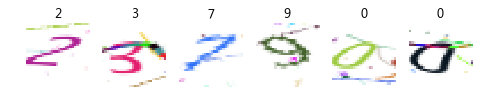

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

# 显示图像
def display(data, labels, i):
    image = data[i]

    # Convert from [0.0, 1.0] -> [0, 255] 
    image = (image*255).astype(int)
  
    if IMAGE_C == 1:
        image = image.reshape(IMAGE_H,IMAGE_W)

    plot_image(image)
    plt.title(onehot2number(labels[i]))
    plt.axis('off')
    
batch_images, batch_labels = data_sets.train.next_batch(6)

plt.figure(figsize=(8,3))
for i in range(len(batch_images)):
    plt.subplot(1, 6, i+1)
    display(batch_images, batch_labels, i)
plt.show()

# 建模训练
## 残差网络模型

In [14]:
# 构造网络模型
from __future__ import absolute_import, division, print_function
import tflearn
import tensorflow as tf
import time

tf.reset_default_graph()
tflearn.config.init_training_mode()

# 提前结束训练，用于保存最好的模型
class EarlyStoppingCallback(tflearn.callbacks.Callback):
    def __init__(self, val_acc_thresh):
        self.val_acc_thresh = val_acc_thresh

    #def on_epoch_end(self, training_state):
    def on_batch_end(self, training_state, snapshot):
        if training_state.val_acc is None: return
        if training_state.val_acc >= self.val_acc_thresh and training_state.acc_value >= self.val_acc_thresh:
            raise StopIteration

    def on_train_end(self, training_state):
        self.val_acc   = training_state.val_acc
        self.acc_value = training_state.acc_value
        print("Successfully left training! Final model accuracy:", training_state.acc_value)


def build_model(learning_rate):
    img_prep = tflearn.ImagePreprocessing()
    #img_prep.add_featurewise_zero_center(per_channel=True)  # 输入图像要减图像均值

    img_aug = tflearn.ImageAugmentation()
    img_aug.add_random_rotation(max_angle=10.0)   # 随机旋转角度
    #img_aug.add_random_blur(sigma_max=5.0)

    # Building Residual Network
    net = tflearn.input_data(shape=[None, IMAGE_H, IMAGE_W, IMAGE_C], 
                             data_preprocessing=img_prep,
                             data_augmentation=img_aug,
                             name='input')

    net = tflearn.conv_2d(net, 16, 3,
                          regularizer='L2',
                          weights_init='variance_scaling',
                          weight_decay=0.0001,
                          name="conv1")  # 卷积处理, 16个卷积，卷积核大小为3，L2 正则化减少过拟合

    net = tflearn.residual_block(net, 1, 16, name="res1")  # 1 个残差层，输出16特征
    net = tflearn.residual_block(net, 1, 32, downsample=True, name="res2")  # 1 个残差层，输出32特征，降维1/2
    net = tflearn.residual_block(net, 1, 64, downsample=True, name="res3")  # 1 个残差层，输出64特征，降维1/2

    # Regression
    net = tflearn.fully_connected(net, len(LABELS), activation='softmax')
    mom = tflearn.Momentum(learning_rate, lr_decay=0.1, decay_step=32000, staircase=True)
    net = tflearn.regression(net, optimizer=mom, loss='categorical_crossentropy')

    # Training
    model = tflearn.DNN(net, max_checkpoints=1, tensorboard_verbose=3)

    return model

model = build_model(learning_rate=0.01)

# Load a model
if tf.gfile.Exists(model_dir +'/model.tfl'+'.index'):
    model.load(model_dir +'/model.tfl')

# Training
fit = True
if fit:
    start_time = time.time()
    fit_cb = EarlyStoppingCallback(val_acc_thresh=0.998)
    try:
        model.fit(data_sets.train.images, 
                  data_sets.train.labels, 
                  validation_set=(
                      data_sets.test.images, 
                      data_sets.test.labels
                  ),
                  n_epoch=100,            # 完整数据集投喂次数，太多或太少会导致过拟合或欠拟合
                  batch_size=100,         # 每次训练获取的样本数
                  shuffle=True,           # 是否对数据进行洗牌
                  show_metric=True,       # 是否显示学习过程中的准确率
                  callbacks=fit_cb,       # 用于提前结束训练
                  run_id='vcode_resnet')


    except StopIteration as e:
        print("early stop")

    # Manually save model
    if not tf.gfile.Exists(model_dir):
        tf.gfile.MakeDirs(model_dir)

    model.save(model_dir +'/model.tfl')
    print('save trained model to ', model_dir +'/model.tfl')   
    
    duration = time.time() - start_time
    print('Training Duration %.3f sec' % (duration))

Training Step: 947  | total loss: 0.02454 | time: 4.251s
| Momentum | epoch: 009 | loss: 0.02454 - acc: 0.9987 -- iter: 1900/3544
Successfully left training! Final model accuracy: 0.9986549019813538


KeyboardInterrupt: 

# 测试

In [ ]:
def display_preds(data, y_trues, y_preds, i):
    image = data[i]

    # Convert from [0.0, 1.0] -> [0, 255] 
    image = (image*255).astype(int)

    plot_image(image)
    y_true = onehot2number(y_trues[i])
    y_pred = onehot2number(y_preds[i])
    plt.title(y_true+(' == ' if y_true==y_pred else ' != ')+'pred('+y_pred+')')
    plt.axis('off')

x_data, y_trues = data_sets.test.next_batch(6)

y_preds = model.predict(x_data)

plt.figure(figsize=(8,3))
for i in range(len(x_data)):
    plt.subplot(2, 3, i+1)
    display_preds(x_data, y_trues, y_preds, i)
plt.show()

# 剔除错误数据
查找原始数据可能就标记错的数据，然后继续训练会进一步提高精度，最终接近100%

In [ ]:
# Predict
x_data, y_trues = images,labels
y_preds = model.predict(x_data)

y_error = []
for i in range(len(y_preds)):
    y_true = y_trues[i].argmax()
    y_pred = y_preds[i].argmax()

    if y_pred != y_true:
        y_error.append(i)
        
acc = 1-len(y_error)/len(y_preds)
print("accuracy: ", acc)

for i in y_error:
    y_true = y_trues[i].argmax()
    y_pred = y_preds[i].argmax()
    print('incorrect', sfiles[i], y_true, ' != ', y_pred)